In [1]:
#Installing packages and loading them into the enviroment
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")

Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'MASS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpuQ4Olb\downloaded_packages


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'missMDA' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpuQ4Olb\downloaded_packages


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpuQ4Olb\downloaded_packages


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0            v purrr   0.3.3       
v tibble  2.99.99.9014     v dplyr   0.8.99.9000 
v tidyr   1.0.2            v stringr 1.4.0       
v readr   1.3.1            v forcats 0.4.0       

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()

Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpuQ4Olb\downloaded_packages


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Installing package into 'C:/Users/daeda/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'mice' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'mice'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\daeda\OneDrive\Documents\R\win-library\3.6\00LOCK\mice\libs\x64\mice.dll to C:\Users\daeda\OneDrive\Documents\R\win-library\3.6\mice\libs\x64\mice.dll: Permission denied"
Warning message:
"restored 'mice'"



The downloaded binary packages are in
	C:\Users\daeda\AppData\Local\Temp\RtmpuQ4Olb\downloaded_packages



Attaching package: 'mice'


The following object is masked from 'package:tidyr':

    complete


The following objects are masked from 'package:base':

    cbind, rbind




In [2]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('spec_shoot_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))

#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [3]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 567)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X
  2   1  S34_X
  3   1  S34_X
  4   1  S34_X
  5   1  S34_X


In [4]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
for (x in 1:10000){ # run 10000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.impute = mean.impute/9999 #divide running total by number of runs to find our average
mean.impute #print this average to the screen

#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
for (x in 1:10000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
}
mean.mice = mean.mice/9999 #divide running total by number of runs to find our average
mean.mice #print this average to the screen

[1] 0.8103421

[1] 0.8103227

|species|spec_as_int|
|---|---|
|acerifolia_x|1|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|
|vulpina_x|8|

In [5]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)

In [6]:
viz.impute <- data.frame(spec = df.impute[1], lda = pred.impute$x)
viz.hybrids <- data.frame(spec = hybrids[1], lda = pred.hybrids$x)
viz.impute$spec = as.factor(viz.impute$spec)
viz.hybrids$spec = as.factor(viz.hybrids$spec)

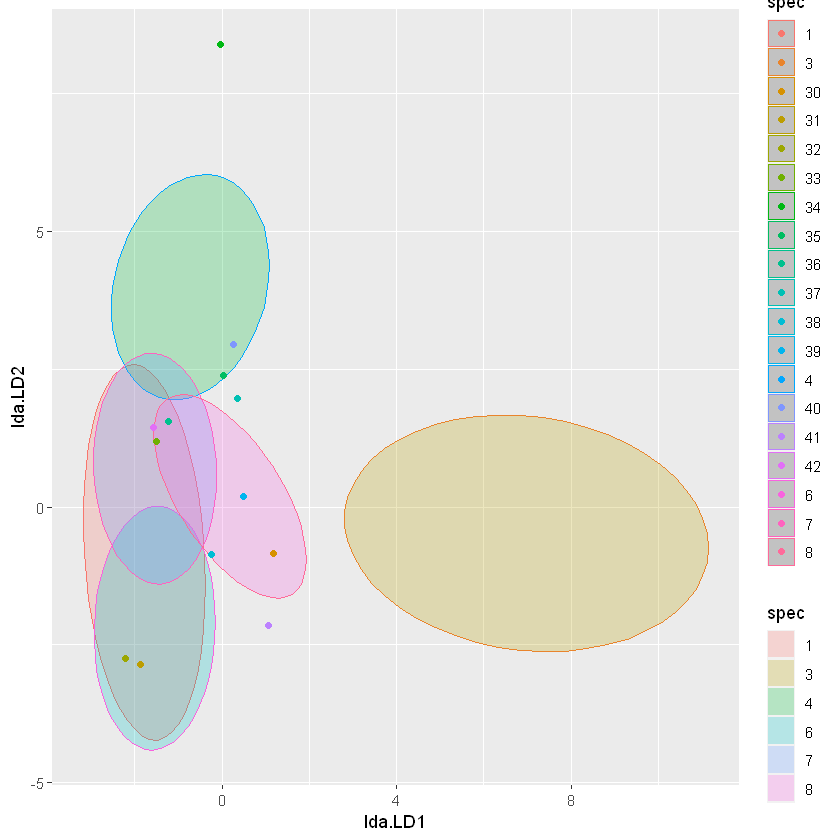

In [23]:
p <- ggplot(data = NULL) 
p <- p + stat_ellipse(data = viz.impute, aes(x = lda.LD1, y = lda.LD2, color = spec, fill = spec),geom = "polygon", alpha = .25) 
p <- p + geom_point(data = viz.hybrids, aes(x = lda.LD1, y = lda.LD2, color = spec))
p

In [ ]:
# Split the data into training (80%) and test set (20%)
#data set imputed via mice
set.seed(321)
training.samples <- ionomicsComplete[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data <- ionomicsComplete[training.samples, ]
test.data <- ionomicsComplete[-training.samples, ]

In [ ]:
#unimputed
training.samples.raw <- ionomics[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.raw <- ionomics[training.samples.raw, ]
test.data.raw <- ionomics[-training.samples.raw, ]

In [ ]:
#data set imputed via missMDA
training.samples.impute <- imputeIonomics$completeObs[,2] %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ]
test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ]
#typecasting from matrix to dataframe
train.data.impute <- unlist(train.data.impute)
test.data.impute <- unlist(test.data.impute)
train.data.impute <- as.data.frame(train.data.impute)
test.data.impute <- as.data.frame(test.data.impute)

In [ ]:
# Fit the model
#data set imputed with mice
model <- lda(spec_as_int~., data = train.data)
# Make predictions
predictions <- model %>% predict(test.data)
# Model accuracy
mean(predictions$class==test.data$spec_as_int)
model

In [ ]:
#unimputed
model.raw <- lda(spec_as_int~., data = train.data.raw)
# Make predictions
predictions.raw <- model.raw %>% predict(test.data.raw)
# Model accuracy
mean(predictions.raw$class==test.data.raw$spec_as_int)
model.raw

In [ ]:
#data set imputed with missMDA
model.impute <- lda(spec_as_int~., data = train.data.impute)
# Make predictions
predictions.impute <- model.impute %>% predict(test.data.impute)
# Model accuracy
mean(predictions.impute$class == test.data.impute$spec_as_int)
model.impute
#TODO format data generated by model

In [ ]:
plot(model,main = "Mice imputed")
plot(model.impute, main = "missMDA imputed")
plot(model.raw, main = "Raw")
#TODO a better way to do this 

In [ ]:
#mice imputed data
# Predicted classes
head(predictions$class, 6)
# Predicted probabilities of class memebership.
head(predictions$posterior, 6) 
# Linear discriminants
head(predictions$x, 3)

In [ ]:
#missMDA imputed data
# Predicted classes
head(predictions.impute$class, 6)
# Predicted probabilities of class memebership.
head(predictions.impute$posterior, 6) 
# Linear discriminants
head(predictions.impute$x, 3)

In [ ]:
#raw data
# Predicted classes
head(predictions.raw$class, 6)
# Predicted probabilities of class memebership.
head(predictions.raw$posterior, 6) 
# Linear discriminants
head(predictions.raw$x, 3)

In [ ]:
#raw data
table.raw <- table(Predicted=predictions.raw$class, Species=test.data.raw$spec_as_int)
confusionMatrix(table.raw)

In [ ]:
#missMDA data
table.impute <- table(Predicted=predictions.impute$class, Species=test.data.impute$spec_as_int)
con <- confusionMatrix(table.impute)
names(con)
names(con$overall)

In [ ]:
#mice data
table <- table(Predicted=predictions$class, Species=test.data$spec_as_int)
confusionMatrix(table)